<a href="https://colab.research.google.com/github/ishi-gupta0711/Honeywell---Flight-Scheduling-Project/blob/main/hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
data_path = "/content/429e6e3f-281d-4e4c-b00a-92fb020cb2fcFlight_Data.xlsx"

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [ ]:
# === STEP 1: Load and Prepare Data ===

data_path = "/content/429e6e3f-281d-4e4c-b00a-92fb020cb2fcFlight_Data.xlsx"

slot_a = pd.read_excel(data_path, sheet_name='6AM - 9AM')
slot_b = pd.read_excel(data_path, sheet_name='9AM - 12PM')

slot_a.columns = slot_b.columns

slot_a['Slot'] = 'A'
slot_b['Slot'] = 'B'
df = pd.concat([slot_a, slot_b], ignore_index=True)

# New section

In [ ]:
df.columns

Index(['S.No', 'Flight Number', 'Date', 'From', 'To', 'Aircraft',
       'Flight time', 'STD', 'ATD', 'STA', 'Unnamed: 10', 'ATA', 'Unnamed: 12',
       'Unnamed: 13', 'Slot'],
      dtype='object')

In [ ]:
df = df[[ 'Flight Number', 'From', 'To', 'Aircraft',   'Flight time', 'STD', 'ATD', 'STA', 'ATA', 'Slot', 'Date']]

In [ ]:
df['Flight Number'].unique()

array(['AI2509', '\xa0', nan, 'AI2625', '6E762', 'QP1891', '6E5352',
       ' 6E1185', '6E5349', 'QO342', '6E6794', '6E446', '6E5223', 'OV760',
       '6E5188', 'GF57', 'AI2603', '6E1601', 'AI2428', ' TK721', '6E 294',
       'AI2771', 'IX1069', 'AI2821', 'AI601', 'SG115', '6E 301', 'AI2873',
       ' QP1410', '6E6133', '6E5246', ' AI623', ' AI2183', ' 6E5172',
       '6E5284', '6E5296', '6E5108', 'AI2851', '6E6543', ' QP1524',
       'AI2354', 'AI2970', '6E5329', '6E5305', '6E333', '6E1451',
       ' 6E5204', '6E6258', '6E532', '6E5281', 'QP1781', 'WY202',
       '6E1011', '6E5193', ' AI2432', '6E6674', '6E2301', '6E2347',
       'AI2739', 'QP1518', 'AI645', '6E6057', 'AI2863', 'AI2960', 'BA134',
       'S5161', '6E1305', 'AI2663', '6E1115', '6E2264', 'AI2579',
       '6E5092', '6E5313', 'AI2430', '6E5165', 'AI2107', 'AI2877',
       '6E791', 'EK505', 'AI695', '6E5181', '6E521', 'AI633', 'AI2994',
       '6E535', '6E624', '6E6118', '6E6087', '6E5321', 'QP1529', 'AI673',
       'VS355'

In [ ]:
flight_numbers = []
previous_flight = None
for row in df.iterrows():
  data = row[1]
  flight = data['Flight Number']
  if flight is np.nan or flight == '\xa0':
    flight_numbers.append(previous_flight)
  else:
    previous_flight = flight
    flight_numbers.append(flight)


In [ ]:
df['Flight Number'] = flight_numbers
df = df.dropna()

In [ ]:
for col in ['STD', 'ATD', 'STA', 'ATA']:
    df = df[df[col] != '—']

In [ ]:
from datetime import datetime

def convert_to_datetime(time_str):
  """Converts a time string like 'Landed 1:37 PM' to a datetime object."""
  if isinstance(time_str, str):
    time_str = time_str.replace('Landed ', '').strip()
    try:
      return datetime.strptime(time_str, '%I:%M %p').time()
    except ValueError:
      return None # Handle cases that don't match the expected format
  return None # Handle non-string inputs

In [ ]:
df['ATA'] = df['ATA'].apply(convert_to_datetime)

In [ ]:
df = df.dropna(subset=['ATA'])

df['STD_datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['STD'].astype(str))
df['ATD_datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['ATD'].astype(str))
df['STA_datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['STA'].astype(str))
df['ATA_datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['ATA'].astype(str))

df['DepartureDelay'] = (df['ATD_datetime'] - df['STD_datetime']).dt.total_seconds() / 60
df['ArrivalDelay'] = (df['ATA_datetime'] - df['STA_datetime']).dt.total_seconds() / 60

/tmp/ipython-input-3095564417.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['STD_datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['STD'].astype(str))
/tmp/ipython-input-3095564417.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ATD_datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['ATD'].astype(str))
/tmp/ipython-input-3095564417.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['STA_datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['STA'].astype(str))
/tmp/ipython-input-3095564417.py:6: UserWarning: Could not infer

In [ ]:
df['Hour'] = df['STD_datetime'].dt.hour
df['Day'] = df['STD_datetime'].dt.day_name()

/tmp/ipython-input-4232420862.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=delay_by_hour.index, y=delay_by_hour.values, palette="viridis")


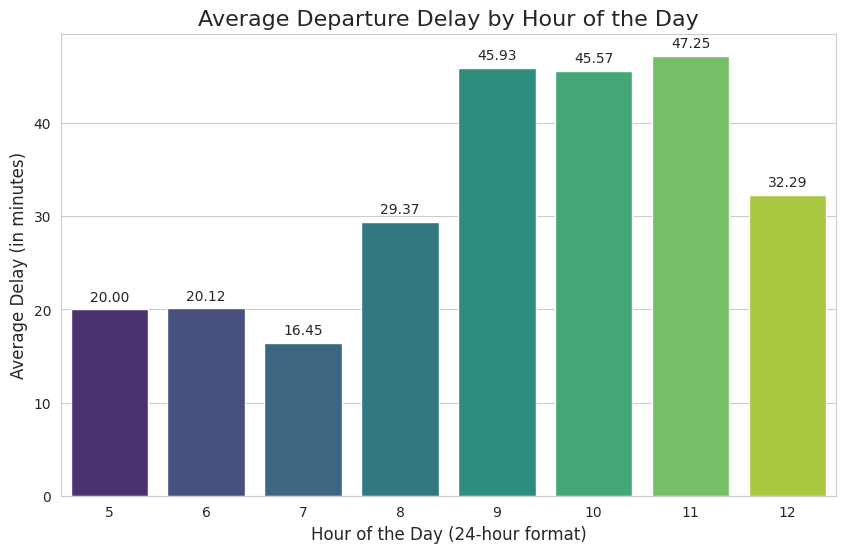

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x=delay_by_hour.index, y=delay_by_hour.values, palette="viridis")

plt.title('Average Departure Delay by Hour of the Day', fontsize=16)
plt.xlabel('Hour of the Day (24-hour format)', fontsize=12)
plt.ylabel('Average Delay (in minutes)', fontsize=12)
plt.xticks(rotation=0)

for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.2f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')

plt.show()

In [ ]:
# QUESTION2


 Busiest hours (highest traffic):


/tmp/ipython-input-4111374315.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  volume_plot = sns.barplot(x=flight_volume.index, y=flight_volume.values, palette='plasma')


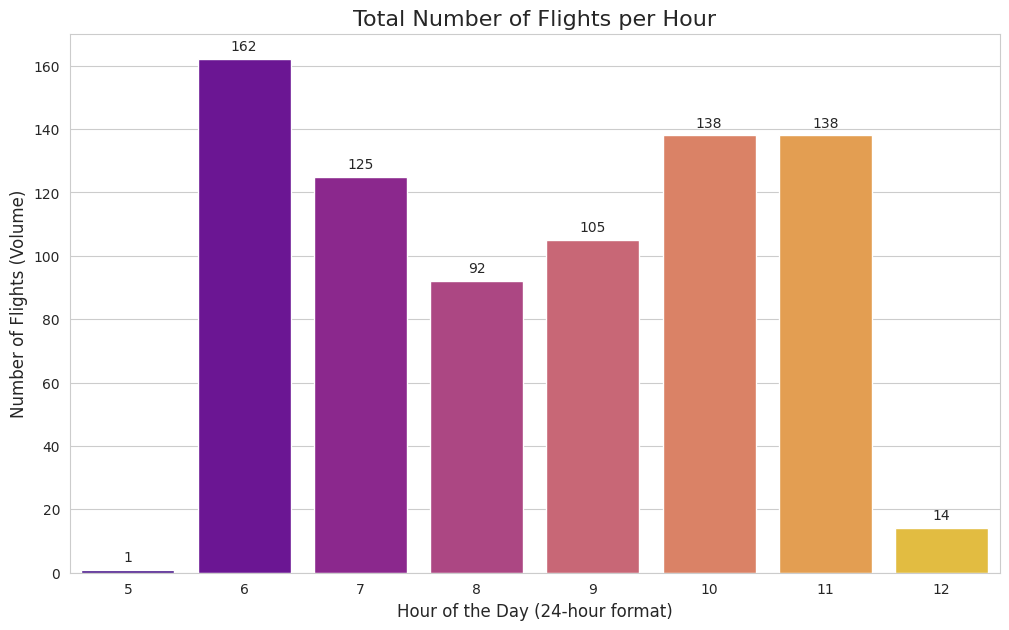

In [ ]:
flight_volume = df.groupby('Hour').size().sort_values(ascending=False)
peak_hours = flight_volume.head(3)
print("\n Busiest hours (highest traffic):")
pd.DataFrame(peak_hours)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

plt.figure(figsize=(12, 7))

volume_plot = sns.barplot(x=flight_volume.index, y=flight_volume.values, palette='plasma')

plt.title('Total Number of Flights per Hour', fontsize=16)
plt.xlabel('Hour of the Day (24-hour format)', fontsize=12)
plt.ylabel('Number of Flights (Volume)', fontsize=12)

for p in volume_plot.patches:
    volume_plot.annotate(format(p.get_height(), '.0f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')

plt.show()

NameError: name 'flight_volume' is not defined

<Figure size 1200x700 with 0 Axes>

In [ ]:
# QUESTION3

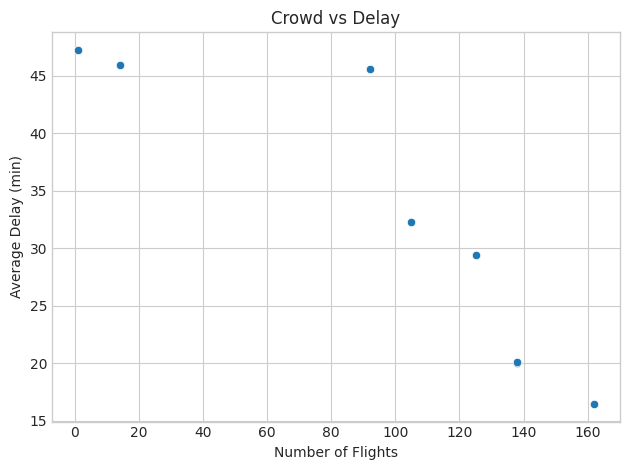

In [ ]:
sns.scatterplot(x=flight_volume.values, y=delay_by_hour.values)
plt.xlabel('Number of Flights')
plt.ylabel('Average Delay (min)')
plt.title('Crowd vs Delay')
plt.tight_layout()
plt.savefig('crowd_vs_delay.png')  # Saves the plot as an image




In [ ]:
hourly_stats = pd.DataFrame({
    'FlightCount': flight_volume,
    'AverageDelay': delay_by_hour
})

hourly_stats.dropna(inplace=True)

print("Combined and Aligned Data:")
print(hourly_stats.head())

Combined and Aligned Data:
      FlightCount  AverageDelay
Hour                           
5               1     20.000000
6             162     20.117284
7             125     16.448000
8              92     29.369565
9             105     45.933333


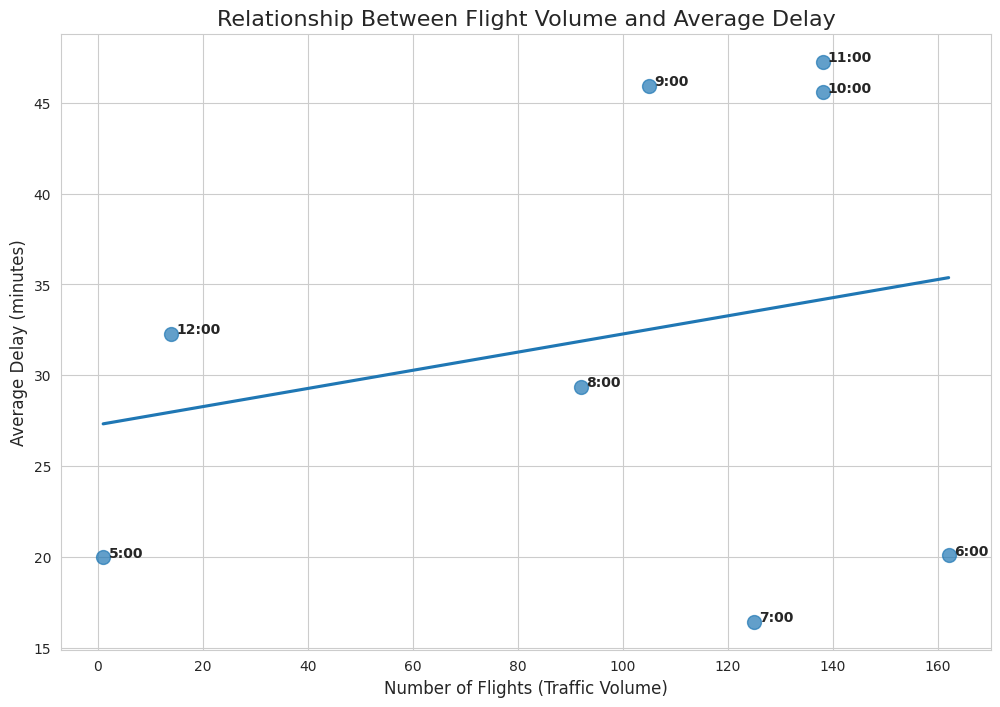

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

reg_plot = sns.regplot(
    data=hourly_stats,
    x='FlightCount',
    y='AverageDelay',
    ci=None,
    scatter_kws={'s': 100, 'alpha': 0.7}

for index, row in hourly_stats.iterrows():
    plt.text(row['FlightCount'] + 1,
             row['AverageDelay'],
             str(index) + ':00',
             fontweight='semibold')

plt.title('Relationship Between Flight Volume and Average Delay', fontsize=16)
plt.xlabel('Number of Flights (Traffic Volume)', fontsize=12)
plt.ylabel('Average Delay (minutes)', fontsize=12)

plt.show()

In [ ]:
#QUESTION4

In [ ]:


model = RandomForestRegressor(random_state=1234, n_estimators=200)
model.fit(features, target)
a = model.score(features, target)
print("Accuracy : ", a)
plt.show()


NameError: name 'features' is not defined

In [ ]:
from langchain.agents.agent_types import AgentType
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from langchain_openai import ChatOpenAI
import os

# Set API Key
# os.environ["OPENAI_API_KEY"] = "YOUR_API_KEY"

# Create the agent that can query the pandas DataFrame
agent = create_pandas_dataframe_agent(
    ChatOpenAI(temperature=0, model="gpt-3.5-turbo-0613"),
    df,
    verbose=True,
    agent_type=AgentType.OPENAI_FUNCTIONS,
)

# Example query
# response = agent.invoke("What is the average departure delay for flights to Delhi?")
# print(response)


ModuleNotFoundError: No module named 'langchain_experimental'

In [ ]:
#QUESTIOM4

In [ ]:
df_sorted = df.sort_values(['AircraftType', 'STD_datetime'])
df_sorted['NextFlight_STD'] = df_sorted.groupby('AircraftType')['STD_datetime'].shift(-1)
df_sorted['NextFlight_ID'] = df_sorted.groupby('AircraftType')['Flight Number'].shift(-1)
df_sorted['TurnaroundGap'] = (df_sorted['NextFlight_STD'] - df_sorted['ATA_datetime']).dt.total_seconds() / 60

df_sorted['CascadingRisk'] = (
    (df_sorted['DepartureDelay'] > 30) &
    (df_sorted['TurnaroundGap'] < 120)
)

cascading_flights = df_sorted[df_sorted['CascadingRisk']]
print("\n Flights with cascading delay risk:")
print(cascading_flights[['Flight Number', 'DepartureDelay', 'TurnaroundGap', 'NextFlight_ID']])

# Score cascading impact
df_sorted['CascadingScore'] = df_sorted['DepartureDelay'] / (df_sorted['TurnaroundGap'] + 1)
top_cascaders = df_sorted.sort_values('CascadingScore', ascending=False).head(10)
print("\n Top cascading delay threats:")
print(top_cascaders[['Flight Number', 'DepartureDelay', 'TurnaroundGap', 'CascadingScore']])

KeyError: 'AircraftType'

In [ ]:
!pip install langchain_experimental
!pip install langchain_openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 8.5 MB/s eta 0:00:00


In [ ]:
from langchain.agents.agent_types import AgentType
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from langchain_community.llms import HuggingFacePipeline # Import HuggingFacePipeline
from transformers import pipeline
import os

# os.environ["OPENAI_API_KEY"] = 'sk-proj-YTUfyZbyDRQvGgXU2YBKDpDw70YwVNTCEQdGCt97gAIBkRUOUaWIL4cgcQxDYariChSp6LIF82TCSqH3tTjOQp6v4aE8PqusNokBpIQHaLfRrvkR6UYK9E7i2ra9qcOdC7LnPt5X09NI6yMJClaZqJ8A'

# Replace with your Hugging Face API token if needed
# os.environ["HUGGINGFACEHUB_API_TOKEN"] = "YOUR_HF_API_TOKEN"

# Choose an appropriate open-source model from Hugging Face Hub
# Example: google/flan-t5-small
model_id = "google/flan-t5-small" # Changed model to flan-t5-small

pipe = pipeline("text2text-generation", model=model_id, device_map="cpu") # Use text2text-generation for flan-t5

llm = HuggingFacePipeline(pipeline=pipe)


agent = create_pandas_dataframe_agent(
    llm,
    df,
    verbose=True,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION, # Use ZERO_SHOT_REACT_DESCRIPTION for HuggingFacePipeline
    allow_dangerous_code=True,
    handle_parsing_errors=True
)

while True:
  user_imput = input()
  if 'quit' in user_imput:
    break
  print(f'User Input: {user_imput}')
  response = agent.invoke(user_imput, handle_parsing_errors=True)
  print(f'AI: {response}')

Device set to use cpu
/usr/local/lib/python3.12/dist-packages/langchain_experimental/agents/agent_toolkits/pandas/base.py:283: UserWarning: Received additional kwargs {'handle_parsing_errors': True} which are no longer supported.
  warnings.warn(


how many rows are there?


Token indices sequence length is longer than the specified maximum sequence length for this model (1139 > 512). Running this sequence through the model will result in indexing errors


User Input: how many rows are there?


> Entering new AgentExecutor chain...


ValueError: An output parsing error occurred. In order to pass this error back to the agent and have it try again, pass `handle_parsing_errors=True` to the AgentExecutor. This is the error: Could not parse LLM output: `[n]`
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE 

In [ ]:
df.to_csv('flight_data.csv', index=False)

In [ ]:
!pip install -U transformers kernels torch
from transformers import pipeline
import torch

model_id = "openai/gpt-oss-20b"

pipe = pipeline(
    "text-generation",
    model=model_id,
    torch_dtype="auto",
    device_map="auto",
)

messages = [
    {"role": "user", "content": "Explain quantum mechanics clearly and concisely."},
]

outputs = pipe(
    messages,
    max_new_tokens=256,
)
print(outputs[0]["generated_text"][-1])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

Using MXFP4 quantized models requires a GPU, we will default to dequantizing the model to bf16


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.17G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.80G [00:00<?, ?B/s]

model-00000-of-00002.safetensors:   0%|          | 0.00/4.79G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/177 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/27.9M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/98.0 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

Device set to use cpu


KeyError: 'model.layers.3.mlp.experts.gate_up_proj'